# Scraping Notícias

In [1]:
# Importar bibliotecas
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

In [21]:
# Carregar base com as urls
urls = pd.read_excel('/content/urls.xlsx', sheet_name ='d24')

In [22]:
# Scraping das notícias
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

linkMateria = []
tituloMateria = []
subTituloMateria = []
dataPublicacao = []
corpoMateria = [] 

for url in urls['urls']: 
  try:

    req = requests.get(url)
    if req.status_code == 200 or 403:
      soup = BeautifulSoup(requests.get(url, headers=headers).content, "html.parser")

      link = url
      titulo = soup.find('h1',class_="blog-post-title").text
      subTitulo = soup.find('h1',class_="blog-post-subtitle").text  
      publicado = soup.find_all('time')[0]['datetime']
      publicado = re.sub(r'(\d{4})-(\d{1,2})-(\d{1,2})', '\\3-\\2-\\1', publicado)

      for article in soup.select('article'):
        p = article.find_all('p')
      corpoMateria.append(p) 

      linkMateria.append(link)
      tituloMateria.append(titulo)
      subTituloMateria.append(subTitulo)
      dataPublicacao.append(publicado)

  except:
    pass

In [26]:
# Converter para df
df = pd.DataFrame(list(zip(linkMateria,tituloMateria,subTituloMateria, dataPublicacao, corpoMateria)), columns=['link','titulo','subtitulo', 'data', 'materia'])
df.head(3)

,link,titulo,subtitulo,data,materia
0,https://d24am.com/amazonas/policia/suspeito-de...,Suspeito de assalto é linchado em rua no Centr...,"Segundo populares, após o roubo, o homem tento...",10-07-2018,"[[[Manaus –], Um homem, ainda não identificad..."
1,http://dezminutos.online/policia/homem-e-espan...,"Homem é espancado após tentar assaltar ônibus,...","Segundo a polícia, o homem estava armado com u...",29-05-2018,"[[[Manaus], – Fabio Brito Costa, 30, foi espa..."
2,http://dezminutos.online/policia/suspeito-de-a...,Suspeito de assaltar mototaxista é espancado p...,"Após o roubo, o suspeito fugiu para uma área d...",17-01-2018,"[[[Manaus – ], Hales Gomes Vasconcelos, 30, fo..."


# Mineração de texto

In [27]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [28]:
# Baixar módulos
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
# Lista de stopwords customizada
stopWords = []

stopwords_pretext = open('/content/stopwords-portugues.txt', 'r')

with stopwords_pretext as f:
    stopwords_pretext = f.read().splitlines()

stopWords = stopwords_pretext

In [30]:
# Unir lista customizada com as palavras da NLTK
stopNLTK = stopwords.words('portuguese')
stopWords += stopNLTK

### Funções

In [31]:
# Função para remover elementos de html
def parser(text):
    return re.sub('<[^<]+?>', '', str(text))

# Função para limpar os textos do título e do subtítulo
def limparTitulos(df):
  replacer = {'\n':' ',"[\[].*?[\]]": "",'[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para limpar o texto das matérias
def limparMateria(df):
  replacer = {'\n':' ','[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para tokenizar os textos
def tokenizar(df):
  df = df.apply(word_tokenize,language='portuguese') 
  return df  

# Função para contar o número de palavras por texto
def contarPalavras(df):
  lists =  df

  words = []
  for wordList in lists:
    words += wordList
  FreqDist(words)

  # Elencar os x termos mais frequentes
  fdist = FreqDist(words)
  
  # Transforma em df
  termos = pd.DataFrame(list(fdist.items()), columns = ["Termos", "Frequência"]).sort_values(by=['Frequência'], ascending=False)
  
  return termos

# Função para gerar as nuvens de palavras
def gerarNuvem(df):
  df = df.set_index('Termos').to_dict()['Frequência']
  wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(df)

  plt.figure(figsize=(10, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return plt.show()

### Pré-processamento

In [32]:
df['materiaLimpa'] = df.materia.apply(parser)
df['tituloLimpo'] = limparTitulos(df['titulo'])
df['subTituloLimpo'] = limparTitulos(df['subtitulo'])
df['cleanmateriaLimpa'] = limparMateria(df['materiaLimpa'])

## Tokenização e frequências

In [33]:
df['tokenizeTitulo'] = tokenizar(df['tituloLimpo'])
df['tokenizeSubTitulo'] = tokenizar(df['subTituloLimpo'])
df['tokenizeMateria'] = tokenizar(df['cleanmateriaLimpa'])

In [34]:
frequenciaTitulo = contarPalavras(df['tokenizeTitulo'])
frequenciaTitulo.head(10) 

,Termos,Frequência
6,espancado,42
0,suspeito,38
5,homem,34
65,agredido,25
15,populares,22
1,assalto,21
2,linchado,19
31,roubar,17
7,tentar,17
12,diz,15


In [35]:
frequenciaSubTitulo = contarPalavras(df['tokenizeSubTitulo'])
frequenciaSubTitulo.head(10)

,Termos,Frequência
2,homem,45
11,policia,38
20,suspeito,22
0,populares,17
142,agredido,16
18,crime,15
4,fugir,15
9,vitima,15
143,acordo,14
229,moradores,12


In [36]:
frequenciaMateria = contarPalavras(df['tokenizeMateria'])
frequenciaMateria.head(10)

,Termos,Frequência
0,homem,193
11,policia,181
85,zona,163
77,suspeito,148
185,bairro,135
19,local,106
6,rua,99
120,policiais,94
90,cicom,94
10,acordo,86


## Nuvem de palavras

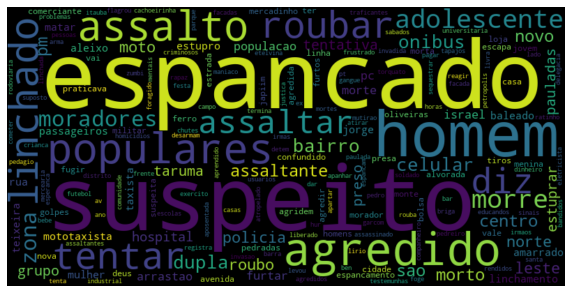

In [37]:
gerarNuvem(frequenciaTitulo)

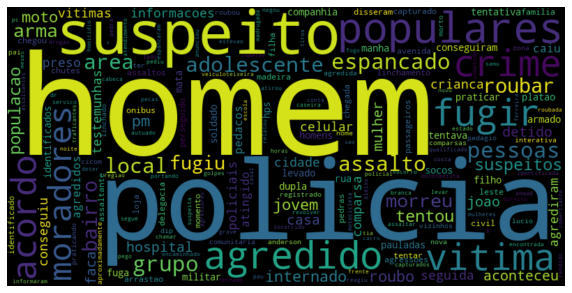

In [38]:
gerarNuvem(frequenciaSubTitulo)

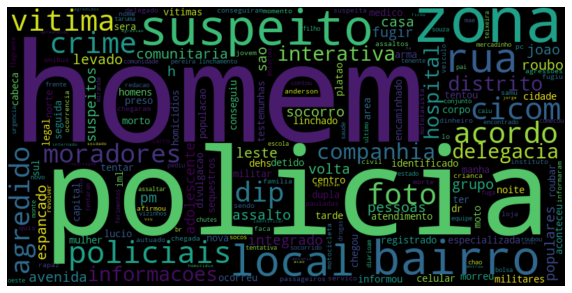

In [39]:
gerarNuvem(frequenciaMateria)